<a href="https://colab.research.google.com/github/Akkito64/DurianClassificationByKeras/blob/main/Fine_Tuning_EfficientnetB7_GoogleColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random as rn

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
%matplotlib inline
import time


# Tensorflow Libraries
from keras import models
import tensorflow as tf
from tensorflow.keras import applications as app
from tensorflow.keras.models import Sequential # Sequential model initialization
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For data pipeline building
from functools import partial
import keras
from keras import backend as K
# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')
# various library seeds

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)

    # Seed value for NumPy
    np.random.seed(seed)

    # Seed value for Python's random library
    rn.seed(seed)

    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [ ]:
# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


# 1. Create a dataframe with the Images and Label

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
# Set the path to the dataset
dataset = '/gdrive/MyDrive/New_dataset_durian/New_dataset/'

def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [ ]:
image_df = image_df.drop_duplicates() # ลบค่าซ้ำออก

In [ ]:
image_df

Filepath      Label
0    /gdrive/MyDrive/New_dataset_durian/New_dataset...  Monthoung
1    /gdrive/MyDrive/New_dataset_durian/New_dataset...  Monthoung
2    /gdrive/MyDrive/New_dataset_durian/New_dataset...  Monthoung
3    /gdrive/MyDrive/New_dataset_durian/New_dataset...  Monthoung
4    /gdrive/MyDrive/New_dataset_durian/New_dataset...  Monthoung
..                                                 ...        ...
455  /gdrive/MyDrive/New_dataset_durian/New_dataset...     chanee
456  /gdrive/MyDrive/New_dataset_durian/New_dataset...     chanee
457  /gdrive/MyDrive/New_dataset_durian/New_dataset...     chanee
458  /gdrive/MyDrive/New_dataset_durian/New_dataset...     chanee
459  /gdrive/MyDrive/New_dataset_durian/New_dataset...     chanee

[460 rows x 2 columns]

In [ ]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

# 3.Data Preprocessing

In [ ]:
BATCH_SIZE = 64
TARGET_SIZE = (224, 224)

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 295 validated image filenames belonging to 4 classes.
Found 73 validated image filenames belonging to 4 classes.
Found 92 validated image filenames belonging to 4 classes.


# 4.Training model

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

258076736/258076736 [==============================] - 2s 0us/step


# 5. Fine Tuning
### Fine-tuning เป็นกระบวนการที่ใช้โมเดลเชิงลึก (deep learning model) ที่มีอยู่แล้ว (pre-trained model) และปรับแต่งค่าของโครงสร้างและน้ำหนักของโมเดลเหล่านี้เพื่อให้มีประสิทธิภาพในงานหรือชุดข้อมูลเฉพาะ โดยไม่ต้องสร้างโมเดลใหม่จากศูนย์ การทำ fine-tuning มักเป็นวิธีที่นิยมในการเรียนรู้เชิงลึกเนื่องจากมีประโยชน์ในกรณีที่คุณมีข้อมูลมากน้อยหรือมีโมเดลที่มีประสิทธิภาพที่ได้กับงานหนึ่งแล้วและต้องการใช้งานในงานอื่น ๆ หรือชุดข้อมูลอื่น ๆ

### ตัวอย่างที่ดีของ fine-tuning คือการใช้โมเดลที่ถูกฝึกในการจำแนกภาพ (image classification) ที่ถูกฝึกด้วยชุดข้อมูลใหญ่เช่น ImageNet และใช้ในงานจำแนกวัตถุในภาพของคุณที่อาจมีขนาดเล็กกว่าและแตกต่างกัน. โมเดลที่ได้ถูกฝึกมาจาก ImageNet มีความสามารถในการรู้จำลักษณะทั่วไปของวัตถุในภาพ และคุณสามารถนำโมเดลนี้มาใช้ในงานจำแนกวัตถุที่เกี่ยวข้องกับคุณเช่นการจำแนกวัตถุในภาพ X-ray หรือการจำแนกชนิดของสัตว์ในภาพสัตว์เลี้ยง โดยที่คุณต้องทำการ fine-tuning เพียงเล็กน้อยเท่านั้น เพื่อให้โมเดลเรียนรู้หลักในงานหรือชุดข้อมูลนั้น.

In [ ]:
#Iterate over all layers in the model
for i, layer in enumerate(pretrained_model.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_1, Trainable = False
Layer 1: Name = rescaling, Trainable = False
Layer 2: Name = normalization, Trainable = False
Layer 3: Name = rescaling_1, Trainable = False
Layer 4: Name = stem_conv_pad, Trainable = False
Layer 5: Name = stem_conv, Trainable = False
Layer 6: Name = stem_bn, Trainable = False
Layer 7: Name = stem_activation, Trainable = False
Layer 8: Name = block1a_dwconv, Trainable = False
Layer 9: Name = block1a_bn, Trainable = False
Layer 10: Name = block1a_activation, Trainable = False
Layer 11: Name = block1a_se_squeeze, Trainable = False
Layer 12: Name = block1a_se_reshape, Trainable = False
Layer 13: Name = block1a_se_reduce, Trainable = False
Layer 14: Name = block1a_se_expand, Trainable = False
Layer 15: Name = block1a_se_excite, Trainable = False
Layer 16: Name = block1a_project_conv, Trainable = False
Layer 17: Name = block1a_project_bn, Trainable = False
Layer 18: Name = block1b_dwconv, Trainable = False
Layer 19: Name = block1b_bn, Trainable = F

In [ ]:
#Access a layer by 0-based index
set_trainable = False
for layer in pretrained_model.layers:
    if layer.name == 'block7a_se_excite':
        set_trainable = True
    if set_trainable:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
    else:
        layer.trainable = False


#Iterate over all layers in the model
for i, layer in enumerate(pretrained_model.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')


Layer 0: Name = input_1, Trainable = False
Layer 1: Name = rescaling, Trainable = False
Layer 2: Name = normalization, Trainable = False
Layer 3: Name = rescaling_1, Trainable = False
Layer 4: Name = stem_conv_pad, Trainable = False
Layer 5: Name = stem_conv, Trainable = False
Layer 6: Name = stem_bn, Trainable = False
Layer 7: Name = stem_activation, Trainable = False
Layer 8: Name = block1a_dwconv, Trainable = False
Layer 9: Name = block1a_bn, Trainable = False
Layer 10: Name = block1a_activation, Trainable = False
Layer 11: Name = block1a_se_squeeze, Trainable = False
Layer 12: Name = block1a_se_reshape, Trainable = False
Layer 13: Name = block1a_se_reduce, Trainable = False
Layer 14: Name = block1a_se_expand, Trainable = False
Layer 15: Name = block1a_se_excite, Trainable = False
Layer 16: Name = block1a_project_conv, Trainable = False
Layer 17: Name = block1a_project_bn, Trainable = False
Layer 18: Name = block1b_dwconv, Trainable = False
Layer 19: Name = block1b_bn, Trainable = F

In [ ]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(224,224),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
])

In [ ]:
inputs = pretrained_model.input
x = augment(inputs)
x = Flatten()(pretrained_model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [ ]:
''' Model Compilation '''
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

#### 1. early_stopping เป็น callback ที่ใช้หยุดการฝึกโมเดลเมื่อโมเดลไม่แสดงพัฒนาการที่ดีขึ้นอีกต่อไป โมเดลจะหยุดการฝึกเมื่อค่า val_loss ไม่ลดลงอีกเป็นเวลา patience epoch

#### 2. restore_best_weights เป็นพารามิเตอร์ที่ระบุให้โมเดลกลับคืนสู่น้ำหนักที่ดีที่สุดที่เคยบันทึกไว้เมื่อโมเดลหยุดการฝึก สิ่งนี้จะช่วยป้องกันไม่ให้โมเดลกลับไปสู่การสูญเสียที่สูงขึ้น

#### 3. reduce_lr เป็น callback ที่ใช้ลด learning rate ของโมเดลเมื่อโมเดลไม่แสดงพัฒนาการที่ดีขึ้นอีกต่อไป โมเดลจะลด learning rate เป็น factor ของค่าปัจจุบันเมื่อค่า val_loss ไม่ลดลงอีกเป็นเวลา patience epoch

##### 4. min_lr เป็นพารามิเตอร์ที่ระบุค่า learning rate ต่ำสุดที่โมเดลจะลดลงถึง

In [ ]:
checkpoint_filepath = "/gdrive/MyDrive/bestweights_finetuning64.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,
                                                                save_weights_only=True,
                                                                monitor='val_acc',
                                                                mode='max',
                                                                save_best_only=True)


early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[model_checkpoint_callback,early_stopping,reduce_lr]
)

Epoch 1/20
5/5 [==============================] - 81s 10s/step - loss: 1.8187 - acc: 0.4203 - val_loss: 2.5998 - val_acc: 0.3699 - lr: 0.0010
Epoch 2/20
5/5 [==============================] - 8s 2s/step - loss: 1.1021 - acc: 0.6068 - val_loss: 2.0049 - val_acc: 0.5753 - lr: 0.0010
Epoch 3/20
5/5 [==============================] - 9s 2s/step - loss: 0.7242 - acc: 0.7186 - val_loss: 1.5923 - val_acc: 0.6027 - lr: 0.0010
Epoch 4/20
5/5 [==============================] - 7s 1s/step - loss: 0.5625 - acc: 0.7864 - val_loss: 1.9611 - val_acc: 0.5890 - lr: 0.0010
Epoch 5/20
5/5 [==============================] - 12s 3s/step - loss: 0.4252 - acc: 0.8610 - val_loss: 1.8030 - val_acc: 0.6301 - lr: 0.0010
Epoch 6/20
5/5 [==============================] - 8s 2s/step - loss: 0.3391 - acc: 0.9017 - val_loss: 0.9870 - val_acc: 0.7534 - lr: 0.0010
Epoch 7/20
5/5 [==============================] - 6s 1s/step - loss: 0.2080 - acc: 0.9288 - val_loss: 1.2097 - val_acc: 0.7260 - lr: 0.0010
Epoch 8/20
5/5 [=

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.65213
Test Accuracy: 80.43%


# 5. Visualizing loss curves

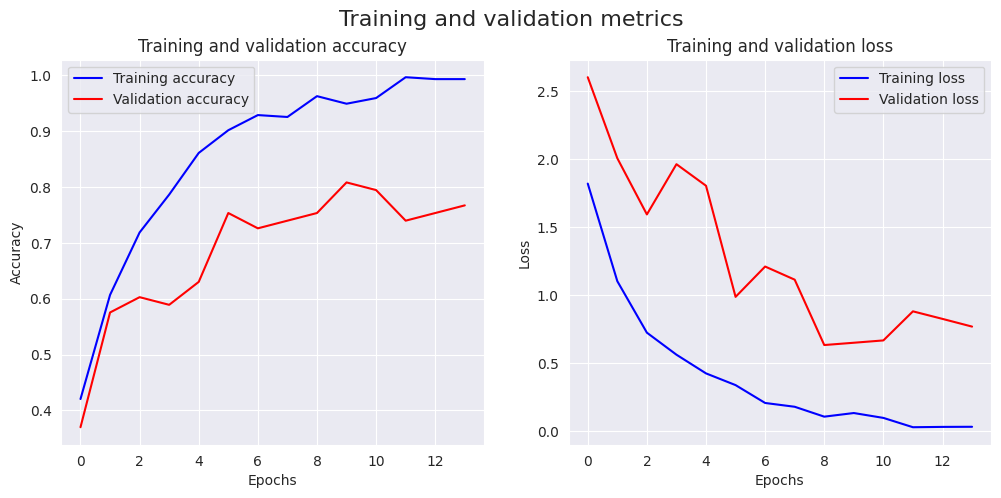

In [ ]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 4 predictions: {pred[:4]}')

2/2 [==============================] - 6s 457ms/step
The first 4 predictions: ['Kanyao', 'Monthoung', 'chanee', 'chanee']


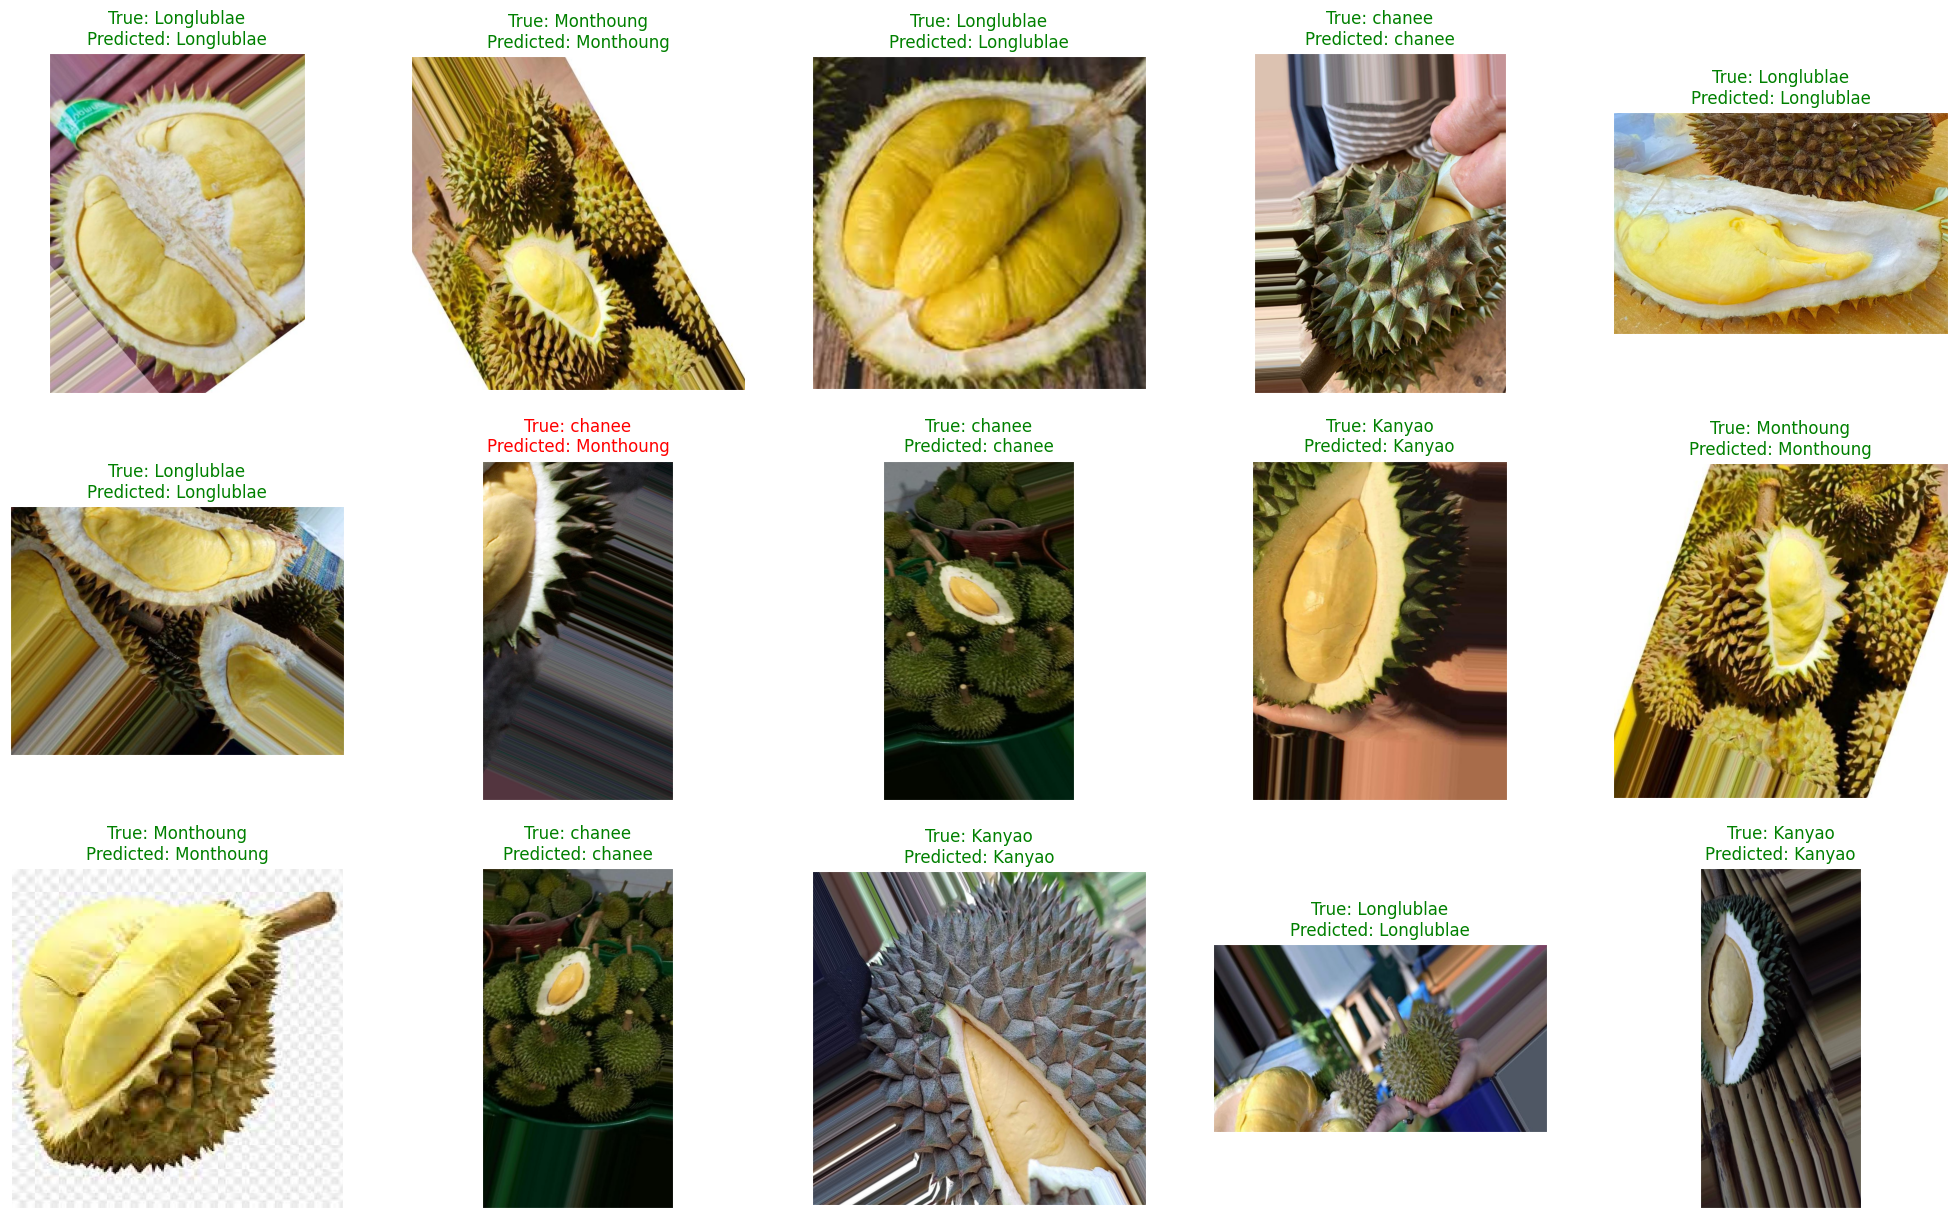

<Figure size 640x480 with 0 Axes>

In [ ]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 6. Plotting the Classification Reports and Confusion Matrix

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      Kanyao       0.74      0.82      0.78        17
  Longlublae       0.85      0.92      0.88        24
   Monthoung       0.70      0.88      0.78        24
      chanee       1.00      0.63      0.77        27

    accuracy                           0.80        92
   macro avg       0.82      0.81      0.80        92
weighted avg       0.83      0.80      0.80        92



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score    support
Kanyao         0.736842  0.823529  0.777778  17.000000
Longlublae     0.846154  0.916667  0.880000  24.000000
Monthoung      0.700000  0.875000  0.777778  24.000000
chanee         1.000000  0.629630  0.772727  27.000000
accuracy       0.804348  0.804348  0.804348   0.804348
macro avg      0.820749  0.811206  0.802071  92.000000
weighted avg   0.832978  0.804348  0.802962  92.000000

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

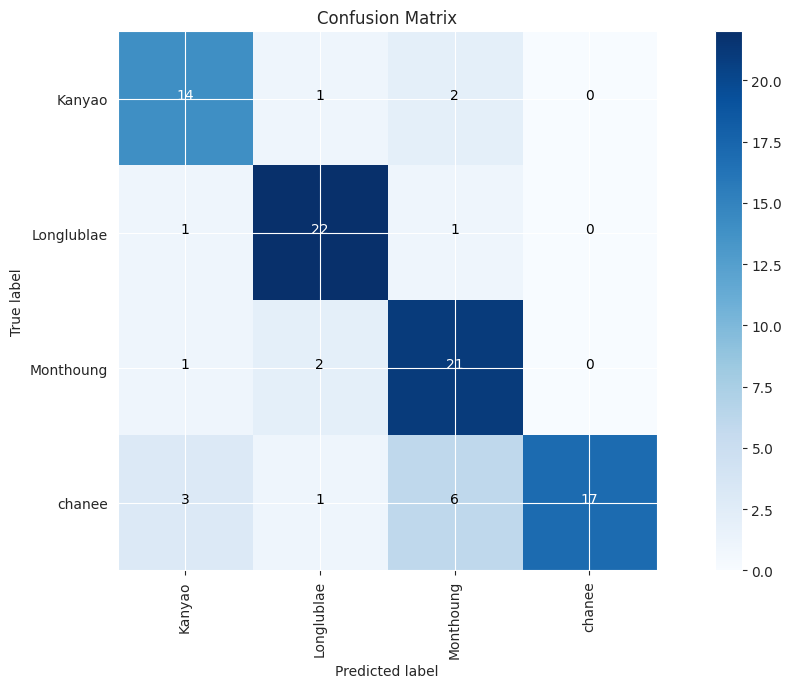

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="/gdrive/MyDrive/cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

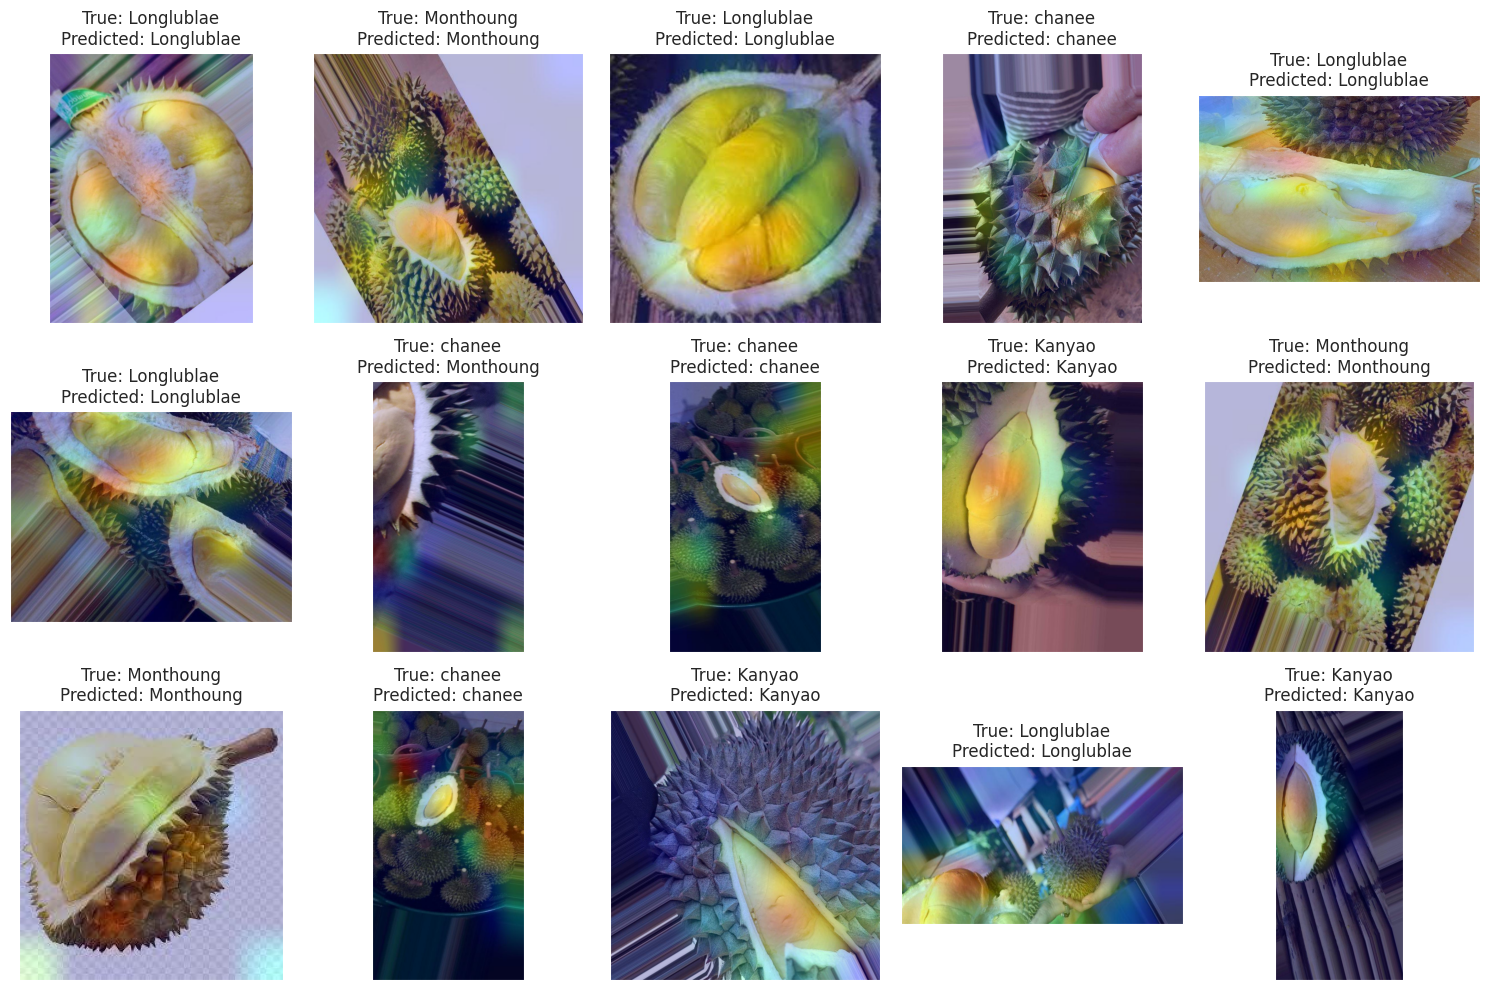

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()